<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Assignment9/EVA_Assignment_9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Preprocessing

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input, Lambda, SpatialDropout2D
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from keras.utils import np_utils
import keras
from keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Mount google drive

In [8]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Model Without Cutout

In [0]:
input = Input(shape=(32, 32, 3,))

#Normal Convoltion
c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(input)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
# c1 = SpatialDropout2D(0.1)(c1)

#######################
# Block1
#######################

b1_c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(c1)
b1_c1 = BatchNormalization()(b1_c1)
b1_c1 = ReLU()(b1_c1)
b1_c1 = SpatialDropout2D(0.1)(b1_c1)

b1_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(c1)
b1_c2 = BatchNormalization()(b1_c2)
b1_c2 = ReLU()(b1_c2)
b1_c2 = SpatialDropout2D(0.1)(b1_c2)


#########
# Trans1
#########
t1 = Concatenate(axis=-1)([c1, b1_c2])

t1 = MaxPooling2D(pool_size=(2, 2))(t1)

t1 = Conv2D(64, (1,1), padding='same', use_bias=False)(t1)
t1 = BatchNormalization()(t1)
t1 = ReLU()(t1)
t1 = SpatialDropout2D(0.1)(t1)

#######################
# Block2
#######################

b2_c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(t1)
b2_c1 = BatchNormalization()(b2_c1)
b2_c1 = ReLU()(b2_c1)
b2_c1 = SpatialDropout2D(0.1)(b2_c1)

b2_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(b2_c1)
b2_c2 = BatchNormalization()(b2_c2)
b2_c2 = ReLU()(b2_c2)
b2_c2 = SpatialDropout2D(0.1)(b2_c2)
#########
# Trans2
#########
t2 = Concatenate(axis=-1)([t1, b2_c2])
t2 = MaxPooling2D(pool_size=(2, 2))(t2)

t2 = Conv2D(64, (1,1), padding='same', use_bias=False)(t2)
t2 = BatchNormalization()(t2)
t2 = ReLU()(t2)
t2 = SpatialDropout2D(0.1)(t2)
#######################
# Block3
#######################
b3_c1 = Conv2D(64, (3,3), padding='same',  use_bias=False)(t2)
b3_c1 = BatchNormalization()(b3_c1)
b3_c1 = ReLU()(b3_c1)
b3_c1 = SpatialDropout2D(0.1)(b3_c1)

b3_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(b3_c1)
b3_c2 = BatchNormalization()(b3_c2)
b3_c2 = ReLU()(b3_c2)
b3_c2 = SpatialDropout2D(0.1)(b3_c2)
#########
# Trans3
#########
t3 = Concatenate(axis=-1)([t2, b3_c2])
# t3 = MaxPooling2D(pool_size=(2, 2))(t3)

# t3 = Conv2D(64, (1,1), padding='same', use_bias=False)(t3)
# t3 = BatchNormalization()(t3)
# t3 = ReLU()(t3)
# t3 = SpatialDropout2D(0.1)(t3)

# #######################
# # Block4
# #######################
# b4_c1 = Conv2D(64, (3,3), padding='same', use_bias=False, name = 'b4_c1')(t3)
# b4_c1 = BatchNormalization()(b4_c1)
# b4_c1 = ReLU()(b4_c1)
# b4_c1 = SpatialDropout2D(0.1)(b4_c1)

# b4_c2 = Conv2D(128, (3,3), padding='same', use_bias=False, name = 'b4_c2')(b4_c1)
# b4_c2 = BatchNormalization()(b4_c2)
# b4_c2 = ReLU()(b4_c2)
# b4_c2 = SpatialDropout2D(0.1)(b4_c2)
# ############
# t4 = Concatenate(axis=-1)([t3, b4_c2])

c_final = Conv2D(256, (3,3), padding='same', use_bias=False, name = 'c_final')(t3)

reduce_ch = Conv2D(10, (1,1), name = 'to_numclass', use_bias=False)(c_final)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)


model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 32, 32, 64)   1728        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 32, 32, 64)   256         conv2d_83[0][0]                  
__________________________________________________________________________________________________
re_lu_88 (ReLU)                 (None, 32, 32, 64)   0           batch_normalization_88[0][0]     
__________________________________________________________________________________________________
conv2d_85 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 29s 76ms/step - loss: 1.7335 - acc: 0.3649 - val_loss: 1.7435 - val_acc: 0.3931
Epoch 2/100
390/390 [==============================] - 25s 64ms/step - loss: 1.3616 - acc: 0.5002 - val_loss: 1.1313 - val_acc: 0.5976
Epoch 3/100
390/390 [==============================] - 25s 64ms/step - loss: 1.2020 - acc: 0.5657 - val_loss: 1.1168 - val_acc: 0.6108
Epoch 4/100
390/390 [==============================] - 25s 64ms/step - loss: 1.0913 - acc: 0.6078 - val_loss: 0.9334 - val_acc: 0.6650
Epoch 5/100
390/390 [==============================] - 25s 64ms/step - loss: 1.0155 - acc: 0.6373 - val_loss: 0.9408 - val_acc: 0.6668
Epoch 6/100
390/390 [==============================] - 25s 65ms/step - loss: 0.9509 - acc: 0.6607 - val_loss: 0.9059 - val_acc: 0.6775
Epoch 7/100
390/390 [==============================] - 25s 65ms/step - loss: 0.9009 - acc: 0.6826 - val_loss: 0.7669 - val_acc: 0.7280
Epoch 8/100
390/390 [==============================] - 25s 64ms/ste

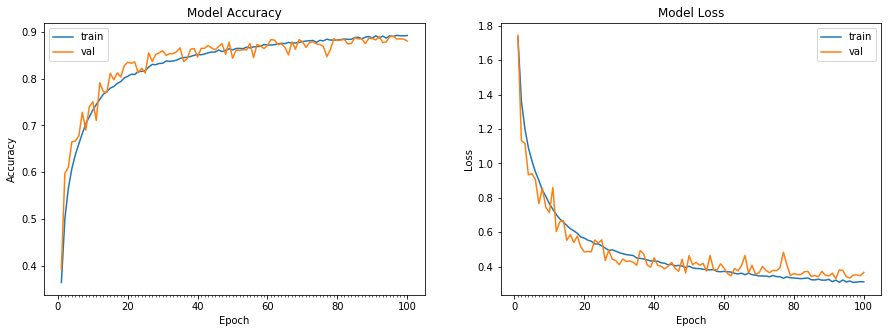

Accuracy on test data is: 88.01


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),
#                                  callbacks=[lr_scheduler],
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [7]:
# save model
# model.save('/content/gdrive/My Drive/EVA2019/Session6/Assignment6A_final.h5')

from keras.models import load_model
# load model back
model = load_model('/content/gdrive/My Drive/EVA2019/Session6/Assignment6A_final.h5')

W0629 13:29:11.209835 140283352868736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 13:29:11.241762 140283352868736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 13:29:11.271577 140283352868736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 13:29:11.272703 140283352868736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0629 13:29:11.273889 140283352

## Gradcam without cutout

In [0]:
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [14]:
image_idx = [208,490,327,559]

for j in image_idx:
  x = test_features[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("c_final")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = (test_features[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype=1)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print (j)
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1

error: ignored

In [0]:
??cv2.addWeighted

In [0]:
import cv2
# from google.colab.patches import cv2_imshow
def whatchyalookingat(j):
  x = test_features[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("c_final")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = (test_features[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0, dtype=cv2.CV_32F)

  concatimg = cv2.hconcat([img,superimposed_img])
  
  return( concatimg)

W0629 13:38:11.180705 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:11.540669 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:11.977224 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:12.345722 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


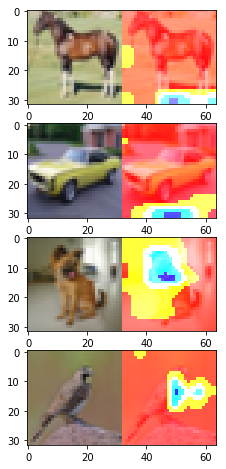

In [21]:
image_idx = [208,490,327,559]
fig = plt.figure(figsize=(8,8))
for i,j in enumerate(image_idx):
  im = whatchyalookingat(j)
  
  ax = fig.add_subplot(4, 1, 1 + i) 
  plt.imshow(im)

  
plt.show()

# Retrain model with cutout

In [0]:
from keras.models import load_model
# load model back
model = load_model('/content/drive/My Drive/EVA2019/Session6/Assignment6A_final.h5')

In [233]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 32, 32, 64)   1728        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 32, 32, 64)   256         conv2d_83[0][0]                  
__________________________________________________________________________________________________
re_lu_88 (ReLU)                 (None, 32, 32, 64)   0           batch_normalization_88[0][0]     
__________________________________________________________________________________________________
conv2d_85 

In [236]:
input = Input(shape=(32, 32, 3,))

#Normal Convoltion
c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(input)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
# c1 = SpatialDropout2D(0.1)(c1)

#######################
# Block1
#######################

b1_c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(c1)
b1_c1 = BatchNormalization()(b1_c1)
b1_c1 = ReLU()(b1_c1)
b1_c1 = SpatialDropout2D(0.1)(b1_c1)

b1_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(c1)
b1_c2 = BatchNormalization()(b1_c2)
b1_c2 = ReLU()(b1_c2)
b1_c2 = SpatialDropout2D(0.1)(b1_c2)


#########
# Trans1
#########
t1 = Concatenate(axis=-1)([c1, b1_c2])

t1 = MaxPooling2D(pool_size=(2, 2))(t1)

t1 = Conv2D(64, (1,1), padding='same', use_bias=False)(t1)
t1 = BatchNormalization()(t1)
t1 = ReLU()(t1)
t1 = SpatialDropout2D(0.1)(t1)

#######################
# Block2
#######################

b2_c1 = Conv2D(64, (3,3), padding='same', use_bias=False)(t1)
b2_c1 = BatchNormalization()(b2_c1)
b2_c1 = ReLU()(b2_c1)
b2_c1 = SpatialDropout2D(0.1)(b2_c1)

b2_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(b2_c1)
b2_c2 = BatchNormalization()(b2_c2)
b2_c2 = ReLU()(b2_c2)
b2_c2 = SpatialDropout2D(0.1)(b2_c2)
#########
# Trans2
#########
t2 = Concatenate(axis=-1)([t1, b2_c2])
t2 = MaxPooling2D(pool_size=(2, 2))(t2)

t2 = Conv2D(64, (1,1), padding='same', use_bias=False)(t2)
t2 = BatchNormalization()(t2)
t2 = ReLU()(t2)
t2 = SpatialDropout2D(0.1)(t2)
#######################
# Block3
#######################
b3_c1 = Conv2D(64, (3,3), padding='same',  use_bias=False)(t2)
b3_c1 = BatchNormalization()(b3_c1)
b3_c1 = ReLU()(b3_c1)
b3_c1 = SpatialDropout2D(0.1)(b3_c1)

b3_c2 = Conv2D(128, (3,3), padding='same', use_bias=False)(b3_c1)
b3_c2 = BatchNormalization()(b3_c2)
b3_c2 = ReLU()(b3_c2)
b3_c2 = SpatialDropout2D(0.1)(b3_c2)
#########
# Trans3
#########
t3 = Concatenate(axis=-1)([t2, b3_c2])
# t3 = MaxPooling2D(pool_size=(2, 2))(t3)

# t3 = Conv2D(64, (1,1), padding='same', use_bias=False)(t3)
# t3 = BatchNormalization()(t3)
# t3 = ReLU()(t3)
# t3 = SpatialDropout2D(0.1)(t3)

# #######################
# # Block4
# #######################
# b4_c1 = Conv2D(64, (3,3), padding='same', use_bias=False, name = 'b4_c1')(t3)
# b4_c1 = BatchNormalization()(b4_c1)
# b4_c1 = ReLU()(b4_c1)
# b4_c1 = SpatialDropout2D(0.1)(b4_c1)

# b4_c2 = Conv2D(128, (3,3), padding='same', use_bias=False, name = 'b4_c2')(b4_c1)
# b4_c2 = BatchNormalization()(b4_c2)
# b4_c2 = ReLU()(b4_c2)
# b4_c2 = SpatialDropout2D(0.1)(b4_c2)
# ############
# t4 = Concatenate(axis=-1)([t3, b4_c2])

c_final = Conv2D(256, (3,3), padding='same', use_bias=False, name = 'c_final')(t3)

reduce_ch = Conv2D(10, (1,1), name = 'to_numclass', use_bias=False)(c_final)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)


model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 33s 84ms/step - loss: 1.8054 - acc: 0.3420 - val_loss: 1.7534 - val_acc: 0.3623
Epoch 2/50
390/390 [==============================] - 26s 68ms/step - loss: 1.4495 - acc: 0.4697 - val_loss: 1.5427 - val_acc: 0.5030
Epoch 3/50
390/390 [==============================] - 27s 68ms/step - loss: 1.2861 - acc: 0.5349 - val_loss: 1.3341 - val_acc: 0.5492
Epoch 4/50
390/390 [==============================] - 27s 68ms/step - loss: 1.1936 - acc: 0.5714 - val_loss: 1.1719 - val_acc: 0.5893
Epoch 5/50
390/390 [==============================] - 26s 68ms/step - loss: 1.1091 - acc: 0.6038 - val_loss: 0.9636 - val_acc: 0.6512
Epoch 6/50
390/390 [==============================] - 26s 68ms/step - loss: 1.0553 - acc: 0.6248 - val_loss: 0.9798 - val_acc: 0.6496
Epoch 7/50
390/390 [==============================] - 27s 68ms/step - loss: 0.9999 - acc: 0.6447 - val_loss: 0.8207 - val_acc: 0.7127
Epoch 8/50
390/390 [==============================] - 27s 69ms/step - los

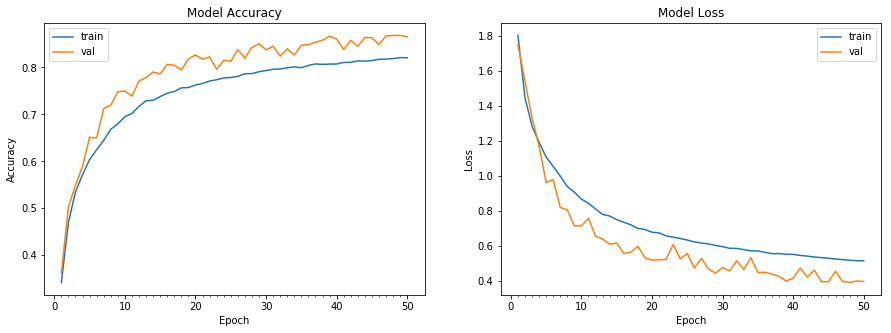

Accuracy on test data is: 86.52


In [238]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),
#                                  callbacks=[lr_scheduler],
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Gradcam after cutout

In [0]:
# save model
# model.save('/content/drive/My Drive/EVA2019/Session9/Assignment9A_cutout.h5')

from keras.models import load_model
# load model back
model = load_model('/content/gdrive/My Drive/EVA2019/Session9/Assignment9A_cutout.h5')

W0629 13:38:42.085960 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:42.622323 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:43.104226 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0629 13:38:43.604291 140283352868736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


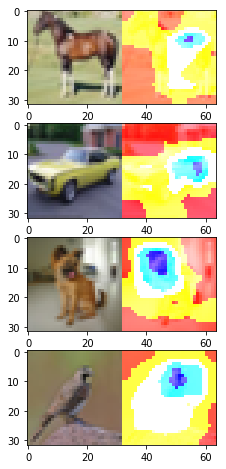

In [23]:
image_idx = [208,490,327,559]
fig = plt.figure(figsize=(8,8))
for i,j in enumerate(image_idx):
  im = whatchyalookingat(j)
  
  ax = fig.add_subplot(4, 1, 1 + i) 
  plt.imshow(im)

  
plt.show()